# Visualize your 🤗 Hugging Face data
#### 🛠️ Installation and set-up

In [1]:
import os
import pandas as pd
import json
import numpy as np
import pickle
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer

import torch
from datasets import load_from_disk, load_metric, Dataset, load_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [2]:
print(os.getcwd())

/zhome/94/5/127021/speciale/master_project/notebooks


### 🛫 Data and model preparation
#### 🏷️ Loading a dataset

In [3]:
# load
datadir = '/work3/s174498/sst2_dataset/'

from_disk = True
all = False

if from_disk:
    test_dataset = load_from_disk(datadir + 'test_dataset')
    if all:
        train_dataset = load_from_disk(datadir + 'train_dataset')
        validation_dataset = load_from_disk(datadir + 'validation_dataset')
else:
    if all:
        dataset = load_dataset("sst2")
        train_dataset = dataset['train']
        validation_dataset = dataset['validation']
        test_dataset = dataset['test']

In [4]:
# load
datadir = '/work3/s174498/sst2_dataset/'
test_0_dataset = load_from_disk(datadir + 'test_0_dataset')
test_1_dataset = load_from_disk(datadir + 'test_1_dataset')


### ⚙️ Tokenizing the dataset
In a typical NLP workflow, we must first tokenize our dataset.

Converting the stream of characters in the text into a stream of defined "tokens", which can be anything from a smaller set of characters to words from a vocabulary.

We will use a pretrained model, so we inherit its tokenization scheme.

Wanting to see all files on RoBERTa e.g. tokenization https://huggingface.co/roberta-base/tree/main 

**Merge**-file explanation https://github.com/huggingface/transformers/issues/4777 

### Files used for the RoBERTa pre-trained Tokenizer 

In [3]:
ellen_little_nb_path = '/zhome/94/5/127021/speciale/master_project/notebooks'
roberta_files_path = '/work3/s174498/roberta_files/'
print('Current wokring directory',os.getcwd())

# load
checkpoint = '/work3/s174498/finetuning-sentiment-model-all-samples-test6/checkpoint-1000'

# tokenizer
tokenizer_checkpoint = RobertaTokenizer.from_pretrained(checkpoint) 
tokenizer_pretrained = RobertaTokenizer.from_pretrained('roberta-base')
# model
model = RobertaForSequenceClassification.from_pretrained(checkpoint,output_hidden_states = True,return_dict = True,)# output_attentions = True, 
model_pretrained = RobertaForSequenceClassification.from_pretrained('roberta-base',output_hidden_states = True,return_dict = True)

Current wokring directory /zhome/94/5/127021/speciale/master_project/notebooks


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [29]:
# merges files
df_merges = pd.read_csv("/work3/s174498/roberta_files/merges.txt", sep=" ",  on_bad_lines='skip')

# dict file
df_dict = pd.read_csv("/work3/s174498/roberta_files/dict.txt", sep=" ", header = None, names = ['id_GPT_2','occurrence'])

# tokenizer file
file = open('/work3/s174498/roberta_files/tokenizer.json')
tokenizer_json = json.load(file)
file.close()

# vocab file
file = open('/work3/s174498/roberta_files/vocab.json')
vocab = json.load(file)
file.close()

In [30]:
df_dict.head()

,id_GPT_2,occurrence
0,13,850314647
1,262,800385005
2,11,800251374
3,284,432911125
4,290,394899794


**Vocab** consists of 50265 'units'

In [31]:
print('vocab length:', len(vocab.keys()))
print('the 10 first:',list(vocab.keys())[:10])

vocab length: 50265
the 10 first: ['<s>', '<pad>', '</s>', '<unk>', '.', 'Ġthe', ',', 'Ġto', 'Ġand', 'Ġof']


**Tokenizer** has a lot of information about model, and which setting are chosen and the vocab can be found here

In [32]:
#tokenizer_json['version']
#tokenizer['model']
#tokenizer['model']['vocab']
#tokenizer_json

### How these files are used  

In [33]:
text = 'A day is just better with Lavazza coffee. You agree?'
print('length of text:',len(text))
print(text)

length of text: 52
A day is just better with Lavazza coffee. You agree?


**1.** First step in the tokenizer is to tokenize according to the merges-file:

In [34]:
print('number of tokens:', len(tokenizer_pretrained.tokenize(text)))
print('tokens from pre-trained:\n',tokenizer_pretrained.tokenize(text))
print('tokens from checkpoint:\n',tokenizer_checkpoint.tokenize(text))

number of tokens: 14
tokens from pre-trained:
 ['A', 'Ġday', 'Ġis', 'Ġjust', 'Ġbetter', 'Ġwith', 'ĠLav', 'az', 'za', 'Ġcoffee', '.', 'ĠYou', 'Ġagree', '?']
tokens from checkpoint:
 ['A', 'Ġday', 'Ġis', 'Ġjust', 'Ġbetter', 'Ġwith', 'ĠLav', 'az', 'za', 'Ġcoffee', '.', 'ĠYou', 'Ġagree', '?']


*Ġ is the rep. for space*

**2.** Second step is to replace these tokens with their corresponding indices, using the vocab-file

In [35]:
print('number of idx:',len(tokenizer_pretrained.encode(text)))
print('indices from pre-trained:\n',tokenizer_pretrained.encode(text))
print('indices from checkpoint:\n',tokenizer_checkpoint.encode(text))

number of idx: 16
indices from pre-trained:
 [0, 250, 183, 16, 95, 357, 19, 18126, 1222, 2478, 3895, 4, 370, 2854, 116, 2]
indices from checkpoint:
 [0, 250, 183, 16, 95, 357, 19, 18126, 1222, 2478, 3895, 4, 370, 2854, 116, 2]


Where the following for end and start of sentence is used 
* sep : ['< /s>', 2] (last token of a sequence built with special tokens)
* cls : ['< s>', 0] (fisrt token of a sequence built with special tokens)

Having the indices we can decode back to original text:

In [36]:
print('decode from pre-trained:\n',tokenizer_pretrained.decode(tokenizer_pretrained.encode(text)))
print('decode from checkpoint:\n',tokenizer_checkpoint.decode(tokenizer_checkpoint.encode(text)))

decode from pre-trained:
 <s>A day is just better with Lavazza coffee. You agree?</s>
decode from checkpoint:
 <s>A day is just better with Lavazza coffee. You agree?</s>


The dict.txt file is the connection between GPT-2 vocab and RoBERTa vocab. 

* Where the **row-idx+4 is the index in RoBERTa** - the 4 is from the 4 special tokens (see below).
* And the column 'index' is the **index from GPT-2.**
* The column 'occurencies' gives the number of times the **index/token appears**' in the training set. 

The GPT-2 vocab is remapped with the RoBERTa vocab and the first four values are the special tokens:

In [37]:
# special tokens
{"<s>": 0, "<pad>": 1, "</s>": 2, "<unk>": 3}

{'<s>': 0, '<pad>': 1, '</s>': 2, '<unk>': 3}

#### Settings for Tokenizer
Tokenizer.json gives all settings for the Tokenizer.

As examples are that it gives which special tokens are added and their corresponding id

In [38]:
nr_add_tokens = len(tokenizer_json['added_tokens'])
for i in range(nr_add_tokens):
    print(tokenizer_json['added_tokens'][i])

{'id': 0, 'special': True, 'content': '<s>', 'single_word': False, 'lstrip': False, 'rstrip': False, 'normalized': True}
{'id': 1, 'special': True, 'content': '<pad>', 'single_word': False, 'lstrip': False, 'rstrip': False, 'normalized': True}
{'id': 2, 'special': True, 'content': '</s>', 'single_word': False, 'lstrip': False, 'rstrip': False, 'normalized': True}
{'id': 3, 'special': True, 'content': '<unk>', 'single_word': False, 'lstrip': False, 'rstrip': False, 'normalized': True}
{'id': 50264, 'special': True, 'content': '<mask>', 'single_word': False, 'lstrip': True, 'rstrip': False, 'normalized': True}


Where **cls** is the classifier token which is used when doing sequence classification (classification of the whole sequence instead of per-token classification)

and **sep** is the separator token, which is used when building a sequence from multiple sequences.

In [39]:
tokenizer_json['post_processor']

{'type': 'RobertaProcessing',
 'sep': ['</s>', 2],
 'cls': ['<s>', 0],
 'trim_offsets': True,
 'add_prefix_space': False}

#### Some of the inputs to the Tokenizer

* **bos_token** (str, optional, defaults to "< s>") — The beginning of sequence token that was used during pretraining. Can be used a sequence classifier token.

* **eos_token** (str, optional, defaults to "< /s>") — The end of sequence token.

* **sep_token** (str, optional, defaults to "< /s>") — The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for sequence classification or for a text and a question for question answering. It is also used as the last token of a sequence built with special tokens.

* **cls_token** (str, optional, defaults to "< s>") — The classifier token which is used when doing sequence classification (classification of the whole sequence instead of per-token classification). It is the first token of the sequence when built with special tokens.

* **unk_token** (str, optional, defaults to "< unk>") — The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this token instead.

* **pad_token** (str, optional, defaults to "< pad>") — The token used for padding, for example when batching sequences of different lengths.

* **mask_token** (str, optional, defaults to "< mask>") — The token used for masking values. This is the token used when training this model with masked language modeling. This is the token which the model will try to predict.

# Prediction 
A little bit of prediction 

In [15]:
test_dataset['sentence'][:5]

['hide new secretions from the parental units ',
 'that loves its characters and communicates something rather beautiful about human nature ',
 'contains no wit , only labored gags ',
 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ',
 'remains utterly satisfied to remain the same throughout ']

In [4]:
# Prepare the text inputs for the model
def preprocess_function(examples):
    return tokenizer_checkpoint(examples["sentence"], truncation=True)

tokenized_test = test_dataset.map(preprocess_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [17]:
# Predicting with model
# predictions = trainer.predict(tokenized_test)
#dataset_test_pred = list(np.argmax(predictions.predictions, axis=-1))

In [5]:
# wanting to save predeictions
load_file = True 

if load_file:
    with open('/work3/s174498/roberta_files/prediction_test6.pickle', 'rb') as handle:
        predictions = pickle.load(handle)
else:
    trainer = Trainer(
        model=model,                        
        tokenizer=tokenizer_checkpoint
    )
    predictions = trainer.predict(tokenized_test)
    with open(f'/work3/s174498/roberta_files/prediction_test6.pickle', 'wb') as handle:
        pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [49]:
test_dataset['sentence'][:5]

['hide new secretions from the parental units ',
 'that loves its characters and communicates something rather beautiful about human nature ',
 'contains no wit , only labored gags ',
 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ',
 'remains utterly satisfied to remain the same throughout ']

In [56]:
predictions.predictions[1][0].mean(axis=2)[:5,:]

array([[ 4.1685998e-06,  1.0261250e-04,  2.3652539e-03,  9.4640936e-04,
         3.2575408e-03,  1.8127499e-03,  3.3260032e-03,  1.8280868e-04,
         1.8126294e-03, -6.6808023e-04,  3.4934215e-03,  5.4416712e-03,
         5.4416712e-03,  5.4416712e-03,  5.4416712e-03,  5.4416712e-03,
         5.4416712e-03,  5.4416712e-03,  5.4416712e-03,  5.4416712e-03,
         5.4416712e-03,  5.4416712e-03,  5.4416712e-03,  5.4416712e-03,
         5.4416712e-03,  5.4416712e-03,  5.4416712e-03,  5.4416712e-03,
         5.4416712e-03,  5.4416712e-03,  5.4416712e-03,  5.4416712e-03,
         5.4416712e-03, -1.0000000e+02, -1.0000000e+02, -1.0000000e+02,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02, -1.0000000e+02,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02, -1.0000000e+02,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02, -1.0000000e+02,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02, -1.0000000e+02,
        -1.0000000e+02, -1.0000000e+02, -1.0000000e+02],
       

### Roberta base results 

In [6]:
with open('/work3/s174498/roberta_files/output_roberta_base.pickle', 'rb') as handle:
    output_pretrained = pickle.load(handle)


In [20]:
print('result/output shape',predictions.predictions[0].shape)
print('hidden layer shape',predictions.predictions[1][0].shape)
print('number of hidden layers',len(predictions.predictions[1]))

result/output shape (1821, 2)
hidden layer shape (1821, 55, 768)
number of hidden layers 13


**Number of hidden layers**: one for the output of the embeddings, if the model has an embedding layer, + one for the output of each layer

In [7]:
embedding_finetuned = predictions.predictions[1][0]
embedding_pretrained = output_pretrained.predictions[1][0]

The following concludes that the embedding part of the model is also finetuned.

In [8]:
num_equal = np.sum(embedding_finetuned == embedding_pretrained)
print(num_equal)    
num_equal/(embedding_finetuned.shape[0]*embedding_finetuned.shape[1]*embedding_finetuned.shape[2])

0


/tmp/ipykernel_17847/3635365693.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  num_equal = np.sum(embedding_finetuned == embedding_pretrained)


0.0

**Last hidden layer** as output visualization 

In [23]:
token_vec = predictions.predictions[1][-1][0]
print('sentence hidden shape:', token_vec.shape)
sentence_output_embedding = np.mean(token_vec, axis = 1)
# or 
# sentence_embedding = np.mean(token_vec, axis = 0)
print('sentence output embedding shape:', sentence_output_embedding.shape)
# sentence_output_embedding

sentence hidden shape: (55, 768)
sentence output embedding shape: (55,)


### Function for visualization 

/zhome/94/5/127021/miniconda3/envs/roberta_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/zhome/94/5/127021/miniconda3/envs/roberta_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/zhome/94/5/127021/miniconda3/envs/roberta_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/zhome/94/5/127021/miniconda3/envs/roberta_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/zhome/94/5/12

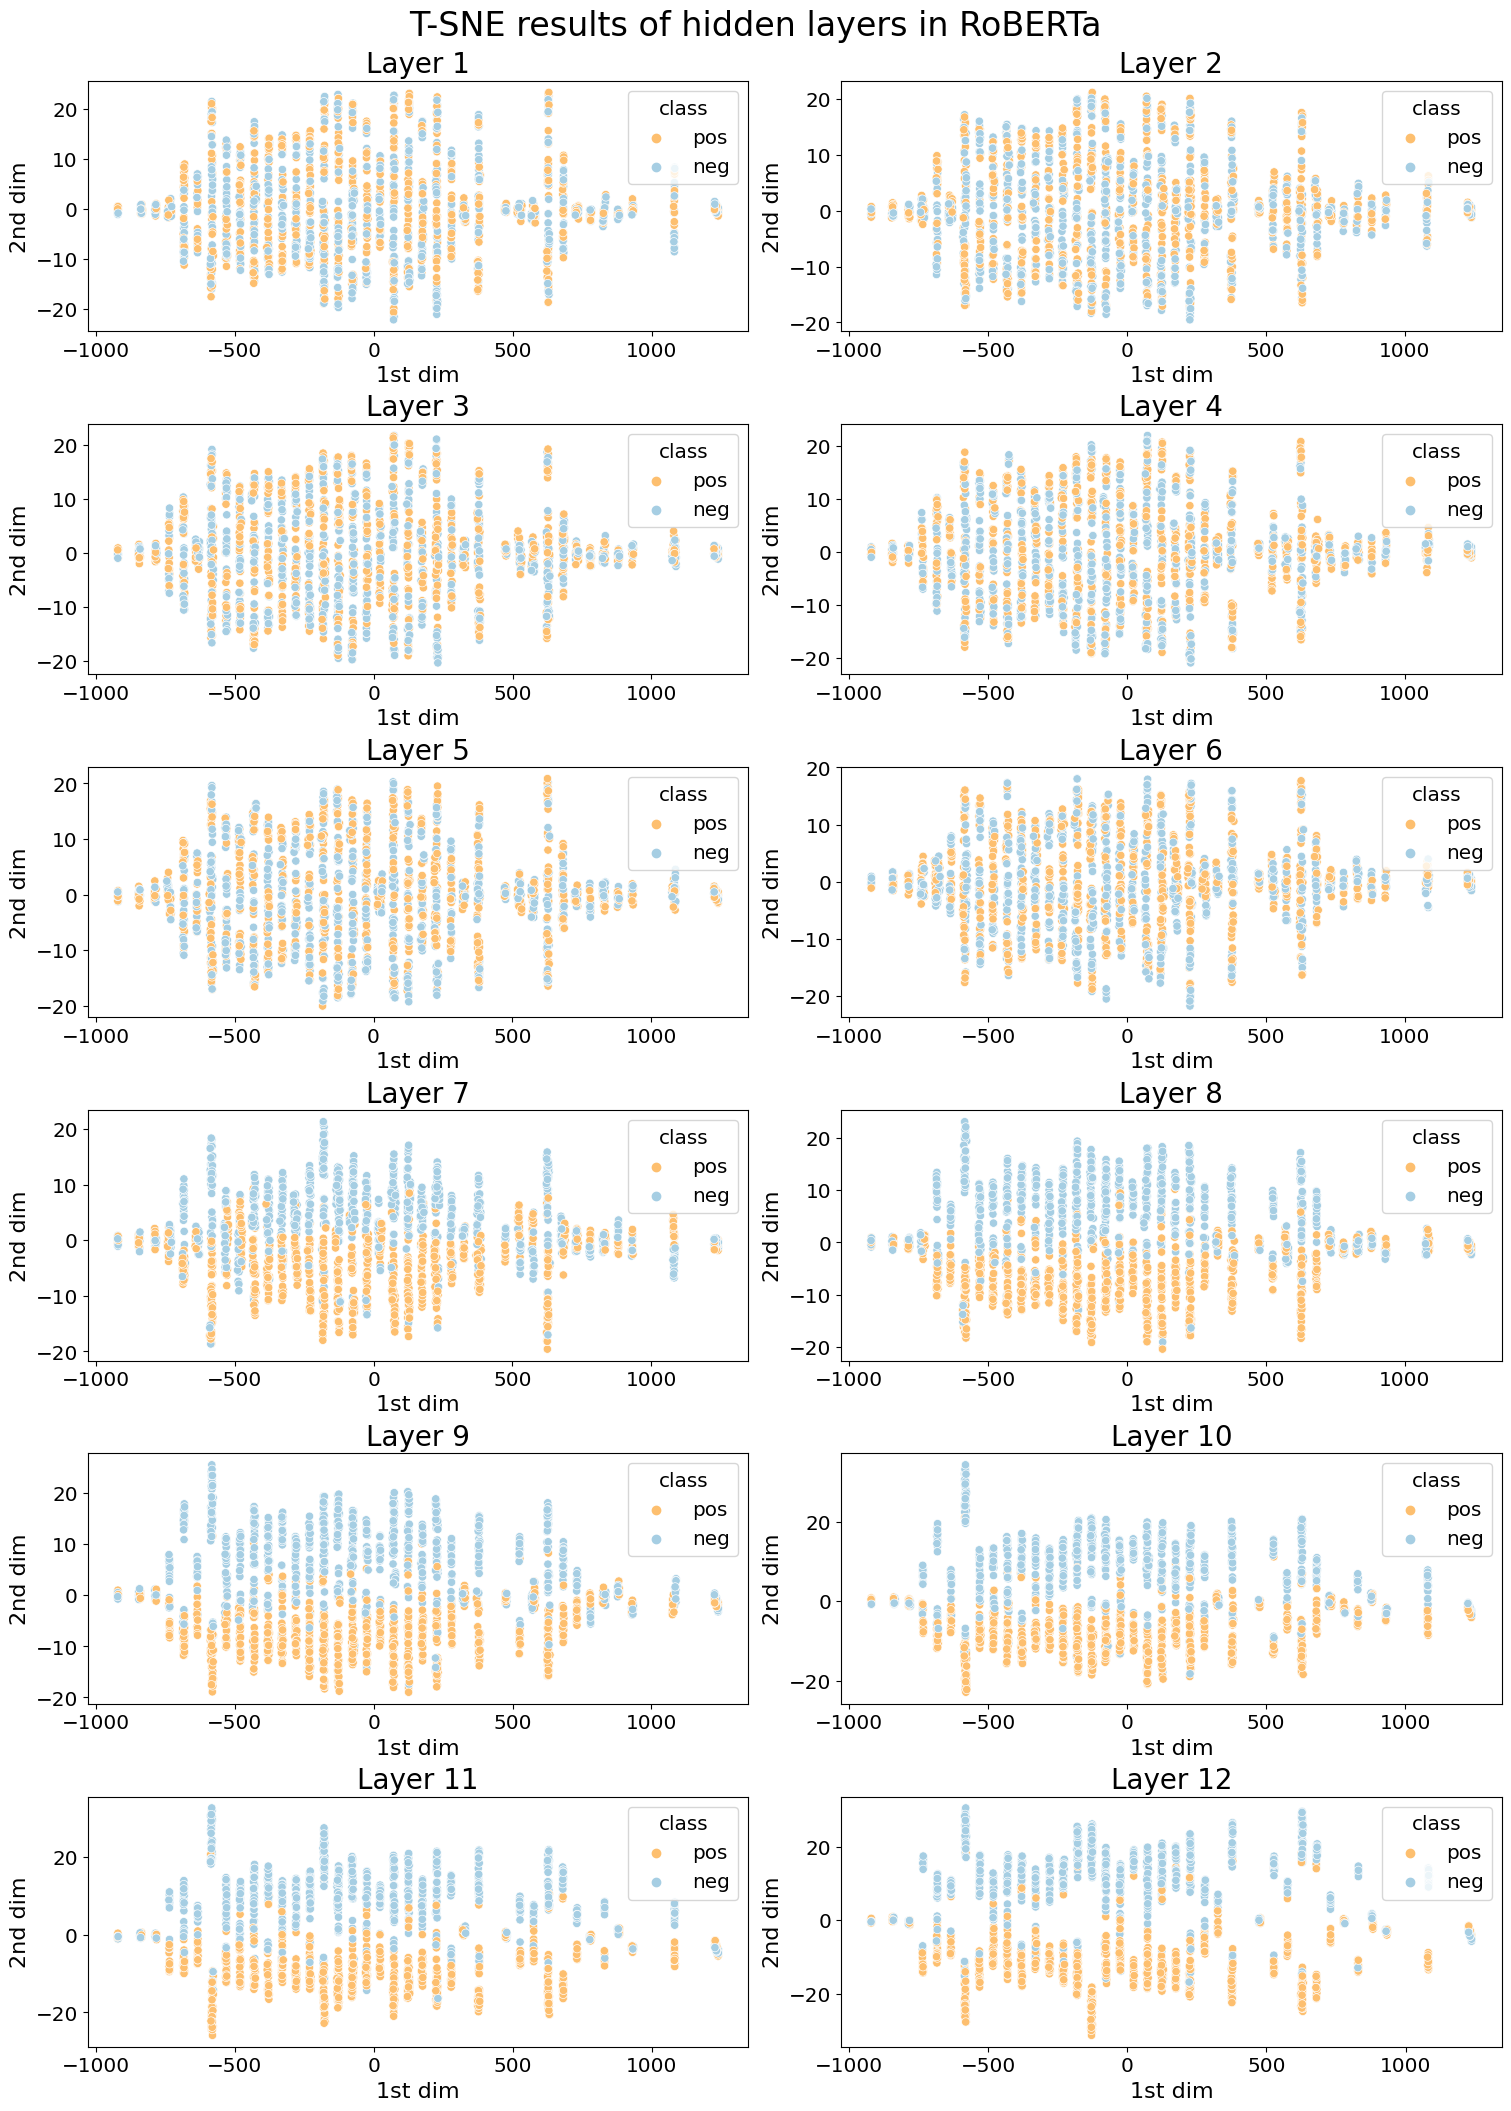

In [24]:
test = False
if test:
    hidden_states = predictions.predictions[1][1:]
    labels = predictions.label_ids
    title = 'finetuned_results'
    layers_to_visualize = [10,11]
    perplexity = 10
    init = 'pca'
    visualize_layerwise_embeddings(hidden_states,labels,title,layers_to_visualize, perplexity, init, save = True)

In [ ]:
#accuracy_metric = load_metric("accuracy")
#accuracy_metric.compute(predictions=, references=test_dataset['label'])

#### Some other text examples

In [ ]:
test_text = [ "It tokenize rare english words in multiple: Obelus, Nudiustertian, Nikehedonia and Metanoia"]

In [ ]:
text = test_text
for i in range(len(text)):
    ids = tokenizer_pretrained(text[i], truncation=True)['input_ids']
    
    print('The tokenizer first tokenizes according to the merges file:\n',tokenizer_pretrained.tokenize(text[i]))
    print('And then(according to the values in the vocab.json)\nthese tokens are then replaced by their indices:\n',ids)

    print(tokenizer_pretrained.decode(ids))
    print(tokenizer_pretrained.convert_ids_to_tokens(ids))

The tokenizer first tokenizes according to the merges file:
 ['It', 'Ġtoken', 'ize', 'Ġrare', 'Ġenglish', 'Ġwords', 'Ġin', 'Ġmultiple', ':', 'ĠOb', 'el', 'us', ',', 'ĠN', 'udi', 'ust', 'ert', 'ian', ',', 'ĠNike', 'hed', 'onia', 'Ġand', 'ĠMet', 'anoia']
And then(according to the values in the vocab.json)
these tokens are then replaced by their indices:
 [0, 243, 19233, 2072, 3159, 47510, 1617, 11, 1533, 35, 5816, 523, 687, 6, 234, 24110, 4193, 2399, 811, 6, 10239, 4183, 15402, 8, 4369, 47733, 2]
<s>It tokenize rare english words in multiple: Obelus, Nudiustertian, Nikehedonia and Metanoia</s>
['<s>', 'It', 'Ġtoken', 'ize', 'Ġrare', 'Ġenglish', 'Ġwords', 'Ġin', 'Ġmultiple', ':', 'ĠOb', 'el', 'us', ',', 'ĠN', 'udi', 'ust', 'ert', 'ian', ',', 'ĠNike', 'hed', 'onia', 'Ġand', 'ĠMet', 'anoia', '</s>']


In [ ]:
# input_ids: the token indices
# attention_mask: exactly ehat it says - a 0 or 1 array that tells the model which tokens should be attended to and which should not

# The truncation argument controls truncation. It can be a boolean or a string:
# True or 'longest_first': 
# truncate to a maximum length specified by the max_length argument or the maximum length accepted by the model if no max_length is provided (max_length=None). 
# This will truncate token by token, removing a token from the longest sequence in the pair until the proper length is reached.

In [ ]:
tokenizer_pretrained(test_dataset['sentence'][:5], padding=True,truncation = True)

{'input_ids': [[0, 37265, 92, 3556, 2485, 31, 5, 20536, 2833, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 6025, 6138, 63, 3768, 8, 39906, 402, 1195, 2721, 59, 1050, 2574, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 10800, 5069, 117, 22094, 2156, 129, 6348, 3995, 821, 8299, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 34084, 6031, 1626, 14, 5, 736, 9, 215, 1368, 9718, 1803, 32353, 25, 36409, 426, 64, 202, 1004, 66, 10, 650, 2156, 1081, 822, 19, 41, 3722, 2204, 1517, 479, 1437, 2], [0, 5593, 5069, 19223, 10028, 7, 1091, 5, 276, 1328, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

We then map the tokenizer over our dataset:

def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=True)

dataset = load_dataset("sst2")

small_train_dataset = dataset["train"].shuffle(seed=42).select([i for i in list(range(100))])
small_val_dataset = dataset["validation"].shuffle(seed=42).select([i for i in list(range(50))])

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_val = small_val_dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
model = RobertaForSequenceClassification.from_pretrained('roberta-base')